# COMPAS Dataset: Decision Trees and KNN Classification Project

This project utilizes the COMPAS dataset to investigate how decision trees and K-Nearest Neighbors (KNN) can be used to predict recidivism risk. COMPAS is a scoring system used in the U.S. judicial system to assess the likelihood that a defendant will reoffend. The project primarily compares the predictive performance of these two classification methods and analyzes the underlying working principles.

At the heart of this research are key factors such as RawScore, gender, and ethnicity, and how they influence prediction outcomes. In addition, the project examines whether using these sensitive features may lead to fairness issues in the models. To further explore fairness, an experiment is conducted by “removing RawScore” to observe its impact on both model accuracy and bias. The study also integrates relevant research and public debates regarding the appropriateness and potential risks of using the COMPAS score in judicial decision-making.



## Data Reading

First, the data is loaded, and the column names and the first five rows of the dataset are displayed. This initial step helps to understand the data structure and identify the key features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Read the data
df = pd.read_csv("data/compas-scores-raw.csv")
print("Dataset columns:", df.columns.tolist())
display(df.head())


Dataset columns: ['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName', 'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text', 'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason', 'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText', 'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText', 'AssessmentType', 'IsCompleted', 'IsDeleted']


,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In this dataset, we focus on the following key fields:

- **DateOfBirth**: The defendant's birth date.
- **RawScore**: The raw risk score.
- **Sex_Code_Text**: Gender information.
- **Ethnic_Code_Text**: Ethnicity information.
- **ScoreText**: The recidivism risk level.

## Data Cleaning and Feature Engineering

In [2]:
# Data Cleaning & Feature Engineering
df["Age"] = pd.to_datetime(df["DateOfBirth"], format="%m/%d/%y", errors="coerce").dt.year
current_year = pd.Timestamp.now().year
df["Age"] = current_year - df["Age"]

# Convert ScoreText into a binary label
df["ScoreText"] = df["ScoreText"].astype(str)
df['binary_label'] = df['ScoreText'].apply(lambda x: 0 if x.strip().lower() == "low" else 1)
y = df['binary_label']

# Feature selection
X = df[["Age", "RawScore", "Sex_Code_Text", "Ethnic_Code_Text"]]

# One-hot encoding for categorical features
X = pd.get_dummies(X, columns=["Sex_Code_Text", "Ethnic_Code_Text"], drop_first=True)

print("First 5 rows of preprocessed X:")
display(X.head())


First 5 rows of preprocessed X:


,Age,RawScore,Sex_Code_Text_Male,Ethnic_Code_Text_African-American,Ethnic_Code_Text_Arabic,Ethnic_Code_Text_Asian,Ethnic_Code_Text_Caucasian,Ethnic_Code_Text_Hispanic,Ethnic_Code_Text_Native American,Ethnic_Code_Text_Oriental,Ethnic_Code_Text_Other
0,33,-2.08,True,False,False,False,True,False,False,False,False
1,33,-1.06,True,False,False,False,True,False,False,False,False
2,33,15.00,True,False,False,False,True,False,False,False,False
3,41,-2.84,True,False,False,False,True,False,False,False,False
4,41,-1.50,True,False,False,False,True,False,False,False,False


The RawScore may have negative values, which is inherent to the dataset.

## Feature Standardization and Dataset Splitting

To ensure that all features are on a similar scale, StandardScaler is applied for normalization. The dataset is then split into a training set (70%) and a test set (30%).


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)
print("Training set shape:", X_train.shape, "Test set shape:", X_test.shape)


Training set shape: (42590, 11) Test set shape: (18253, 11)


## KNN Classifier

### KNN Model Training

A KNN classifier (with k=5) is trained for the binary classification task to predict whether a defendant is at risk of recidivism. The model's accuracy, confusion matrix, and classification report are computed.

In [7]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, knn_pred))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, knn_pred))
print("KNN Classification Report:\n", classification_report(y_test, knn_pred))


KNN Accuracy: 0.9413794992603955
KNN Confusion Matrix:
 [[12066   363]
 [  707  5117]]
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96     12429
           1       0.93      0.88      0.91      5824

    accuracy                           0.94     18253
   macro avg       0.94      0.92      0.93     18253
weighted avg       0.94      0.94      0.94     18253



The results indicate that the KNN classifier achieves approximately 94% accuracy, with high precision and recall for both "Non-Recidivism" and "Recidivism" classes.

### Impact of Different k Values
- **k=3**：KNN Accuracy: 0.9434613488193722
- **k=5**：KNN Accuracy: 0.9422560674957541
- **k=7**：KNN Accuracy: 0.9413794992603955

In practice, model performance under different k values is similar; the optimal choice depends on whether the business needs emphasize recall or precision.



## KNN Decision Boundary Visualization

Using only two features (Age and RawScore) for visualization, a KNN model (with k=7) is trained and its decision boundary is plotted over a fine grid. This visualization illustrates how the model partitions the feature space.

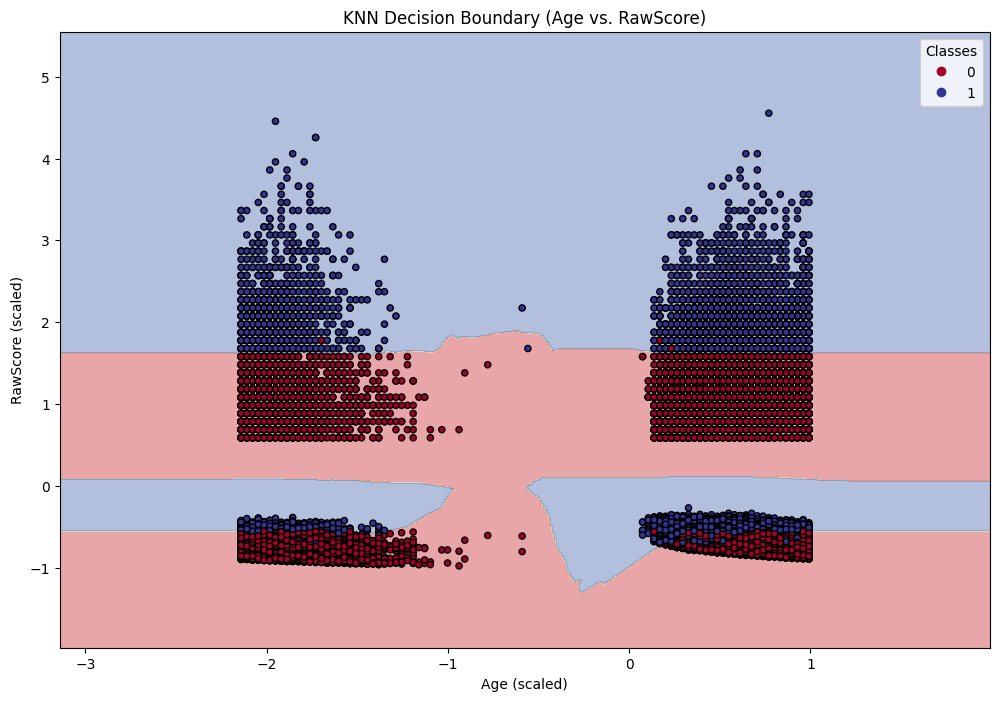

In [8]:

X_vis = X[['Age', 'RawScore']]
X_vis_scaled = scaler.fit_transform(X_vis)

X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
    X_vis_scaled, y, test_size=0.3, random_state=42
)

knn_vis = KNeighborsClassifier(n_neighbors=7)
knn_vis.fit(X_train_vis, y_train_vis)

# Generate grid for visualization
x_min, x_max = X_vis_scaled[:, 0].min() - 1, X_vis_scaled[:, 0].max() + 1
y_min, y_max = X_vis_scaled[:, 1].min() - 1, X_vis_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, 0.01),
    np.arange(y_min, y_max, 0.01)
)

# Predict the class for each point on the grid
Z = knn_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting the decision boundary
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
scatter = plt.scatter(
    X_train_vis[:, 0], X_train_vis[:, 1], c=y_train_vis,
    cmap=plt.cm.RdYlBu, edgecolor='k', s=20
)
plt.xlabel('Age (scaled)')
plt.ylabel('RawScore (scaled)')
plt.title('KNN Decision Boundary (Age vs. RawScore)')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


In the resulting plot, the red regions indicate areas predicted as high-risk (recidivism), while the blue regions represent low-risk areas. The scatter points indicate the actual labels. Observations include:

- Higher RawScore values tend to be classified as recidivism.
- Age influences predictions under certain boundary conditions.
- The KNN decision boundary is irregular due to its reliance on the distribution of neighboring points.

## Decision Tree Model Training and Structure Analysis

### Training the Decision Tree Model

A decision tree classifier with a maximum depth of 5 is trained and evaluated on the test set.

In [11]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print("Decision Tree Confusion Matrix:\n", confusion_matrix(y_test, dt_pred))
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_pred))

Decision Tree Accuracy: 0.9069194105078617
Decision Tree Confusion Matrix:
 [[11409  1020]
 [  679  5145]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93     12429
           1       0.83      0.88      0.86      5824

    accuracy                           0.91     18253
   macro avg       0.89      0.90      0.89     18253
weighted avg       0.91      0.91      0.91     18253



The decision tree shows an overall accuracy of about 91%. It performs stably on the low-risk class but is slightly less effective in identifying high-risk cases.

### Recursive Printing of the Decision Tree Structure
To better understand the splitting logic at each node, a recursive function is defined to print details such as the feature used for splitting, the threshold, Gini impurity, the number of samples, and the class distribution.


In [12]:
def print_tree_details(clf, feature_names, node_index=0, depth=0):
    """
    Recursively prints detailed information for each node in the decision tree:
      - Feature name (feature)
      - Threshold (threshold)
      - Gini impurity (impurity)
      - Number of samples (n_node_samples)
      - Class counts (value)
    """
    left_child = clf.tree_.children_left[node_index]
    right_child = clf.tree_.children_right[node_index]
    threshold = clf.tree_.threshold[node_index]
    feature = clf.tree_.feature[node_index]
    impurity = clf.tree_.impurity[node_index]
    n_samples = clf.tree_.n_node_samples[node_index]
    value = clf.tree_.value[node_index]

    indent = "  " * depth
    if left_child == -1 and right_child == -1:
        print(f"{indent}Leaf node {node_index}:")
        print(f"{indent}  gini = {impurity:.3f}, samples = {n_samples}, value = {value}")
    else:
        print(f"{indent}Node {node_index}:")
        print(f"{indent}  If {feature_names[feature]} <= {threshold:.3f} (gini = {impurity:.3f}, samples = {n_samples}, value = {value}):")
        print_tree_details(clf, feature_names, left_child, depth + 1)
        print_tree_details(clf, feature_names, right_child, depth + 1)

feature_names = X.columns.tolist()
print_tree_details(dt, feature_names)


Node 0:
  If RawScore <= 1.629 (gini = 0.434, samples = 42590, value = [[29058. 13532.]]):
  Node 1:
    If RawScore <= -0.700 (gini = 0.381, samples = 38983, value = [[29012.  9971.]]):
    Leaf node 2:
      gini = 0.000, samples = 11505, value = [[11505.     0.]]
    Node 3:
      If RawScore <= 0.159 (gini = 0.462, samples = 27478, value = [[17507.  9971.]]):
      Node 4:
        If RawScore <= -0.555 (gini = 0.484, samples = 16887, value = [[6916. 9971.]]):
        Node 5:
          If Ethnic_Code_Text_African-American <= 0.113 (gini = 0.471, samples = 11105, value = [[6889. 4216.]]):
          Leaf node 6:
            gini = 0.378, samples = 5998, value = [[4479. 1519.]]
          Leaf node 7:
            gini = 0.498, samples = 5107, value = [[2410. 2697.]]
        Node 8:
          If RawScore <= -0.542 (gini = 0.009, samples = 5782, value = [[  27. 5755.]]):
          Leaf node 9:
            gini = 0.063, samples = 801, value = [[ 26. 775.]]
          Leaf node 10:
         

From the printed tree, it is evident that the **RawScore** feature is used repeatedly as a splitting criterion, underscoring its strong discriminative power in the COMPAS dataset. Although sensitive features such as gender and ethnicity appear in later nodes, they may still affect the final decision.

### Decision Tree Visualization
The decision tree is also visualized graphically using **plot_tree** to facilitate an intuitive understanding of the splitting logic.

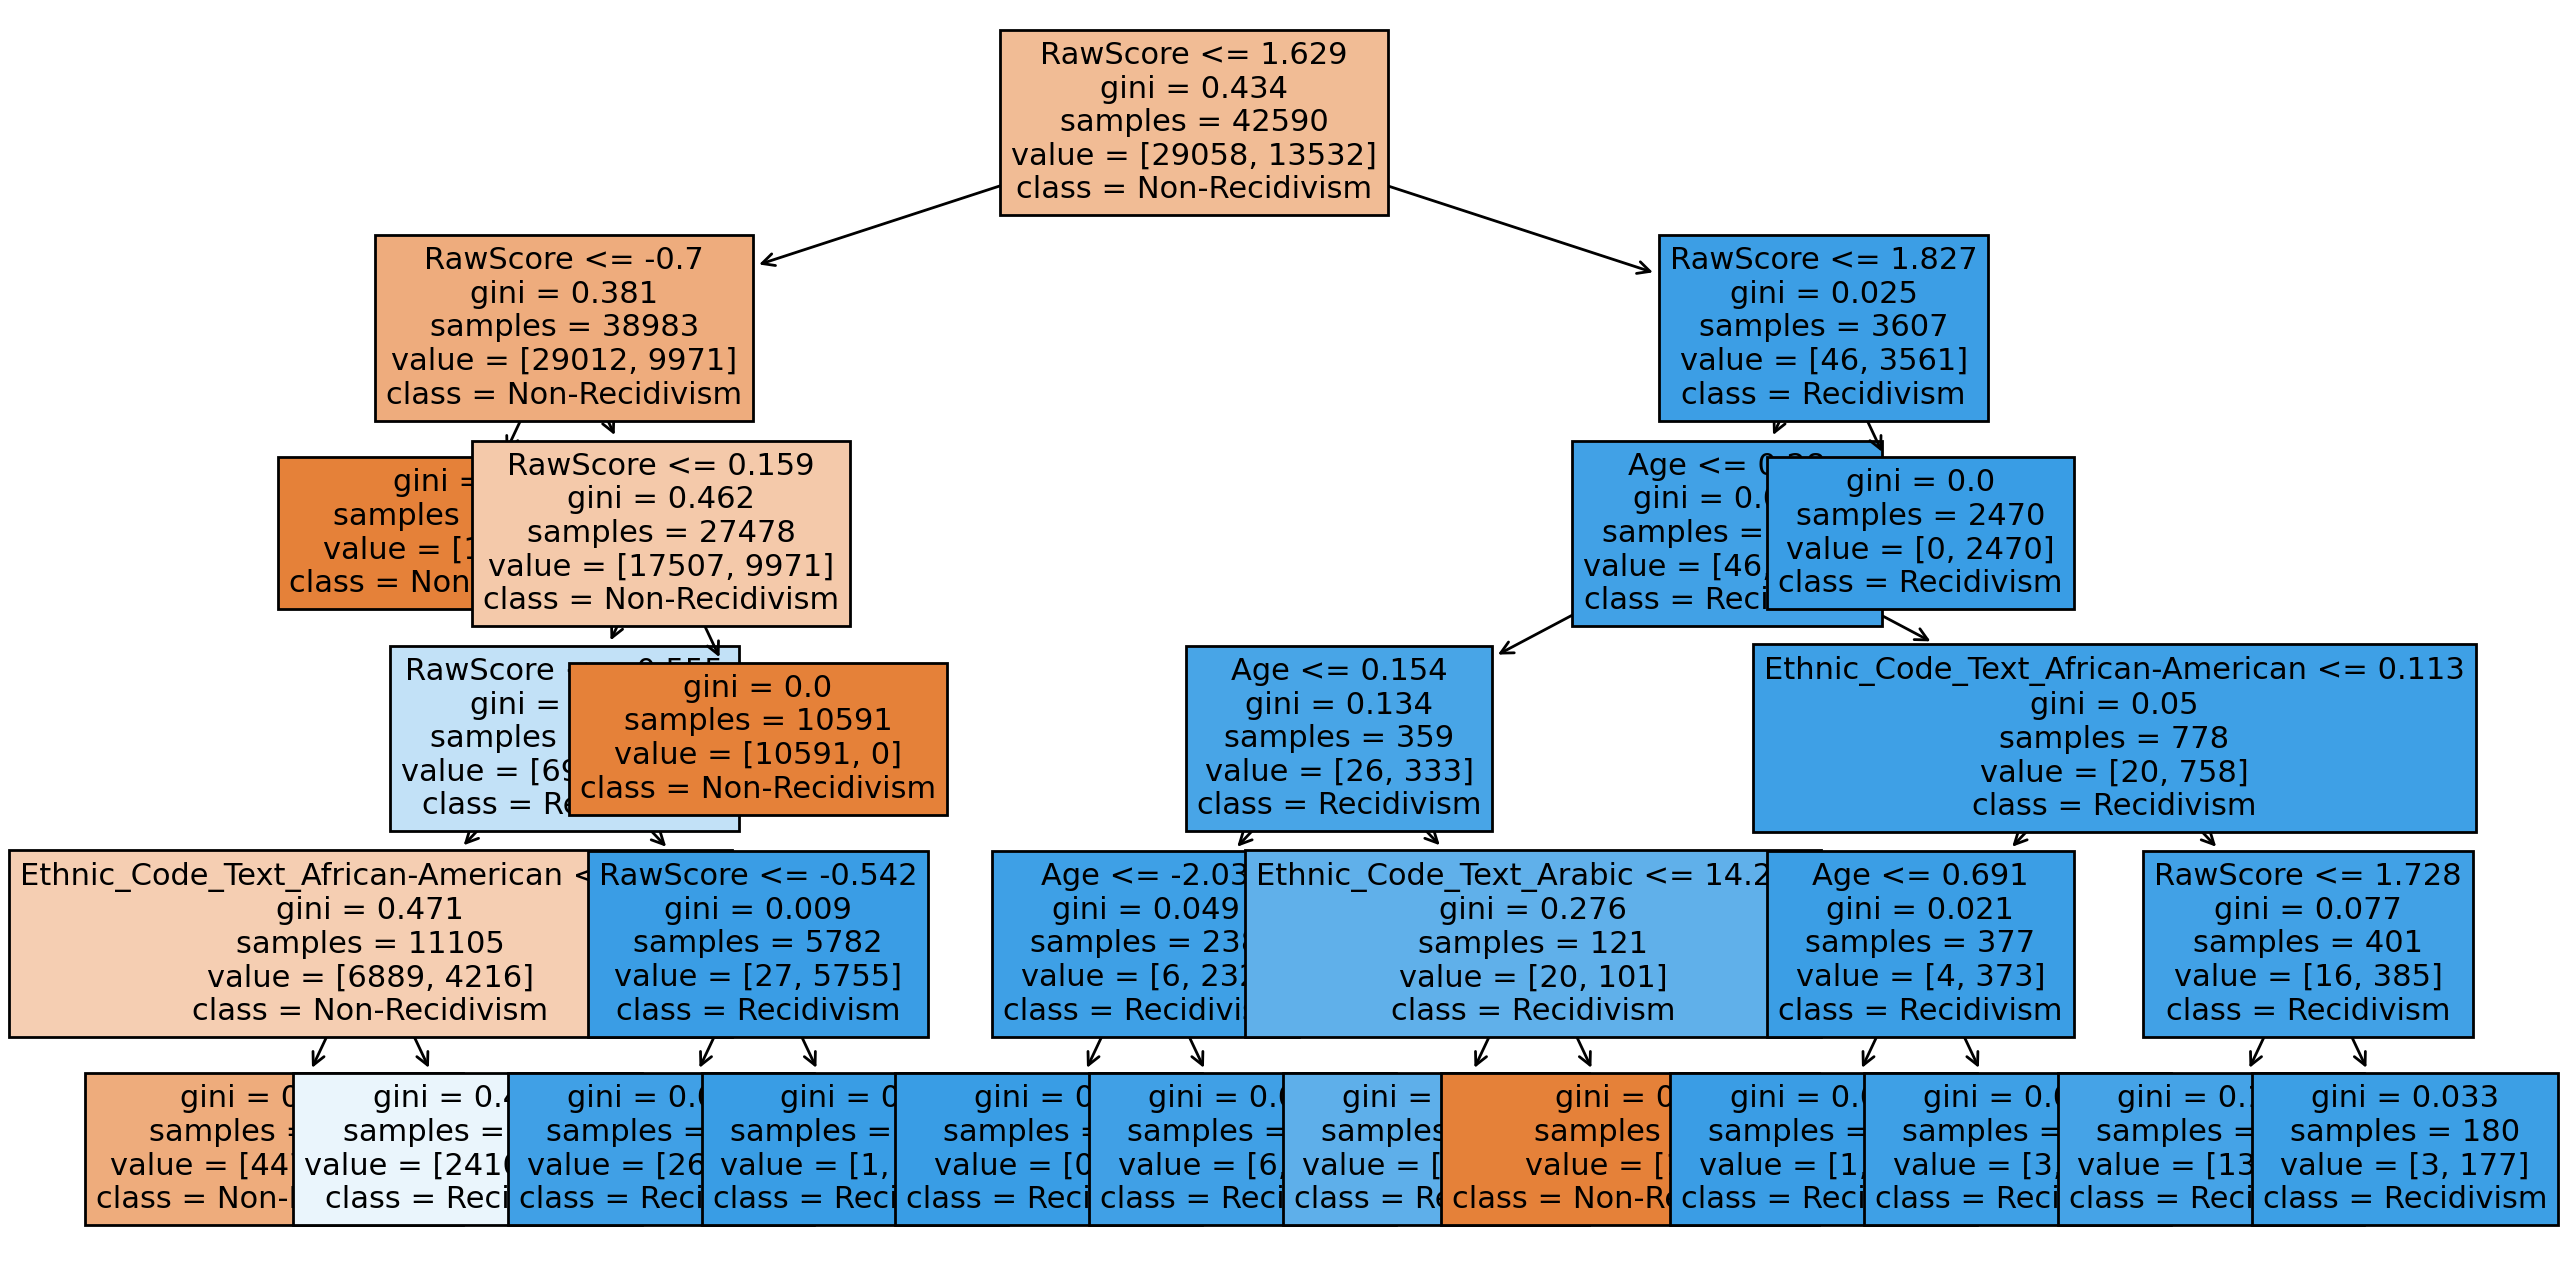

In [13]:
plt.figure(figsize=(15, 8), dpi=200)
plot_tree(
    dt,
    feature_names=feature_names,
    class_names=["Non-Recidivism", "Recidivism"],
    fontsize=11,
    filled=True
)
plt.show()


## Experiment: Removing RawScore

In further experiments, I removed the RawScore feature to observe the impact on model accuracy and bias.

###  Impact of Removing RawScore on KNN and Decision Tree
- **KNN**  
  When RawScore is completely removed, the KNN model’s accuracy drops sharply from approximately 93% (with RawScore) to about 65.7%. The ability to correctly identify high-risk (recidivism) cases decreases markedly.
- **Decision Tree**  
  Without RawScore, the decision tree’s accuracy falls from around 88–89% to roughly 70%. Moreover, the model starts misclassifying many high-risk samples as low risk. In the absence of a strong discriminative feature like RawScore, the decision tree relies more heavily on features such as race, gender, and age for splitting. In some cases, race even appears as the primary splitting feature at the root node, potentially exacerbating inherent biases.



## Reflection and References

1. **Role and Limitations of RawScore**  
   RawScore, the “raw risk score” in the COMPAS system, integrates a variety of factors including a defendant’s criminal history, social relationships, and psychological measurements. It has strong discriminative power in predicting recidivism risk, often dominating the decision process in models. However, because the specific computation of COMPAS scores is not publicly disclosed, the transparency of the algorithm is limited. The hidden weightings may inadvertently inherit biases from historical data, posing potential fairness risks despite its predictive strength.

2. **Fairness Issues and Social Debate**  
   To validate the potential bias, previous studies and public discussions have been referenced. For instance, ProPublica’s investigation titled “Machine Bias” highlighted significant error rate differences across ethnic groups in COMPAS scores, showing that Black defendants were more likely to be incorrectly flagged as high-risk, while white defendants tended to have their risk underestimated. This finding has sparked extensive ethical debates over the reliability and fairness of such scoring systems in judicial decisions. Additionally, research by Dressel & Farid (2018) titled The accuracy, fairness, and limits of predicting recidivism suggests that the predictive accuracy of COMPAS is comparable to that of simpler statistical models, implying that its complex scoring mechanism may not necessarily yield superior outcomes. The study further indicates that even without explicitly using race or gender, models may still indirectly incorporate bias through proxy variables (such as address or social network), which are highly correlated with ethnicity.

4. **Trade-off Between Model Performance and Fairness**  
   The experiments show that removing RawScore leads to a significant decrease in model accuracy—especially in detecting high-risk groups. This indicates that while RawScore provides crucial predictive information, its use may also introduce fairness issues. In the absence of strong discriminative features, models are more likely to rely on sensitive attributes such as gender and ethnicity, thereby amplifying bias.



## Ethical Considerations and Use of Language Models

This project has utilized ChatGPT to assist in generating and optimizing the code. 